In [22]:
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools, Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem

In [23]:
from xgboost import XGBRegressor

In [24]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
from sklearn.linear_model import Lasso, LinearRegression

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error

In [26]:
import matplotlib.pyplot as plt

In [27]:
from rdkit.Chem import Descriptors

In [28]:
from rdkit import __version__

In [29]:
print(__version__)

2024.03.5


In [30]:
full = ['PI_COUNT',
 'NI_COUNT',
 'AR_COUNT',
 'H_COUNT',
 'HBD_COUNT',
 'HBA_COUNT',
 'XBD_COUNT',
 'XBA_COUNT',
 'HVY_ATOM_COUNT',
 'ROT_BOND_COUNT',
 'TOTAL_HYD',
 'LOGP',
 'TPSA',
 'ENV_HBA_OCC_SUM',
 'ENV_HBA_OCC_MAX',
 'ENV_HBD_OCC_SUM',
 'ENV_HBD_OCC_MAX',
 'PI_AR_SCORE_SUM',
 'PI_AR_SCORE_MAX',
 'AR_PI_SCORE_SUM',
 'AR_PI_SCORE_MAX',
 'H_H_SCORE_SUM',
 'H_H_SCORE_MAX',
 'AR_AR_SCORE_SUM',
 'AR_AR_SCORE_MAX',
 'HBD_HBA_SCORE_SUM',
 'HBD_HBA_SCORE_MAX',
 'HBA_HBD_SCORE_SUM',
 'HBA_HBD_SCORE_MAX',
 'XBD_XBA_SCORE_SUM',
 'XBD_XBA_SCORE_MAX',
 'ES_ENERGY',
 'ES_ENERGY_SQRD_DIST',
 'VDW_ENERGY_ATT',
 'VDW_ENERGY_REP',]

small = ['ENV_HBA_OCC_SUM',
 'ENV_HBA_OCC_MAX',
 'ENV_HBD_OCC_SUM',
 'ENV_HBD_OCC_MAX',
 'PI_AR_SCORE_SUM',
 'PI_AR_SCORE_MAX',
 'AR_PI_SCORE_SUM',
 'AR_PI_SCORE_MAX',
 'H_H_SCORE_SUM',
 'H_H_SCORE_MAX',
 'AR_AR_SCORE_SUM',
 'AR_AR_SCORE_MAX',
 'HBD_HBA_SCORE_SUM',
 'HBD_HBA_SCORE_MAX',
 'HBA_HBD_SCORE_SUM',
 'HBA_HBD_SCORE_MAX',
 'XBD_XBA_SCORE_SUM',
 'XBD_XBA_SCORE_MAX',
 'ES_ENERGY',
 'ES_ENERGY_SQRD_DIST',
 'VDW_ENERGY_ATT',
 'VDW_ENERGY_REP',]

In [31]:
df = pd.merge(PandasTools.LoadSDF('../data/exp_data/CatS/gc4scoreset.sdf'),
              pd.read_csv('../data/Descriptors/CatS/gc4scoreset.csv'), 
              on=PandasTools.LoadSDF('../data/exp_data/CatS/gc4scoreset.sdf').index)

In [32]:
df['r_canvas_IC50_[um]'] = df['r_canvas_Affinity']

In [33]:
df.shape

(465, 96)

In [34]:
df['SMILES'] = df.apply(lambda x: Chem.MolToSmiles(x['ROMol'], isomericSmiles=True), axis=1)

In [35]:
df = df.sort_values('r_i_docking_score').drop_duplicates('SMILES')

In [36]:
df.shape

(465, 97)

In [37]:
df['pIC50'] = np.log10(df['r_canvas_IC50_[um]'].astype(float))*-1+6

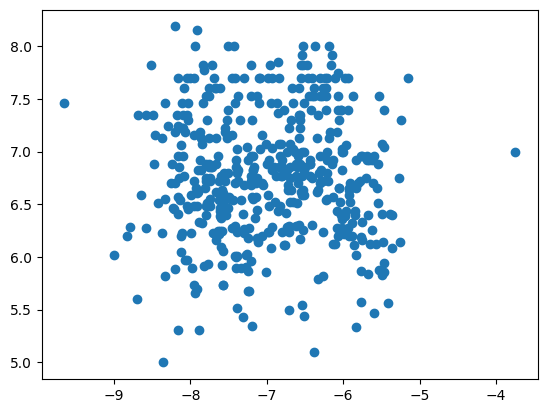

In [38]:
plt.scatter(df['r_i_docking_score'].astype(float), df['pIC50']);

In [39]:
df_train = df

In [40]:
df_train.shape

(465, 98)

In [41]:
df_test = PandasTools.LoadSDF('../data/exp_data/CatS/gc4FEset.sdf')
df_test = pd.merge(df_test, pd.read_csv('../data/Descriptors/CatS/gc4FEset.csv'), on=df_test.index)
df_test['pIC50'] = np.log10(df_test['r_canvas_Affinity'].astype(float))*-1+6
df_test['SMILES'] = df_test.apply(lambda x: Chem.MolToSmiles(x['ROMol'], isomericSmiles=True), axis=1)
df_test = df_test.sort_values('r_i_docking_score').drop_duplicates('SMILES')

In [42]:
df_test.shape

(32, 97)

In [43]:
sum([x in df_test['SMILES'].values for x in df_train['SMILES'].values])

28

In [44]:
sum([x in df_train['SMILES'].values for x in df_test['SMILES'].values])

28

In [45]:
df_train = df_train[[x not in df_test['SMILES'].values for x in df_train['SMILES'].values]]

In [46]:
sum([x in df_test['SMILES'].values for x in df_train['SMILES'].values])

0

In [47]:
sum([x in df_train['SMILES'].values for x in df_test['SMILES'].values])

0

In [48]:
df_train.shape

(437, 98)

In [49]:
df_rdkit = pd.DataFrame([Descriptors.CalcMolDescriptors(x) for x in df_train['ROMol'].values])

[16:14:57] DEPRECATION WARNING: please use MorganGenerator
[16:14:57] DEPRECATION WARNING: please use MorganGenerator
[16:14:57] DEPRECATION WARNING: please use MorganGenerator
[16:14:57] DEPRECATION WARNING: please use MorganGenerator
[16:14:57] DEPRECATION WARNING: please use MorganGenerator
[16:14:57] DEPRECATION WARNING: please use MorganGenerator
[16:14:57] DEPRECATION WARNING: please use MorganGenerator
[16:14:57] DEPRECATION WARNING: please use MorganGenerator
[16:14:57] DEPRECATION WARNING: please use MorganGenerator
[16:14:58] DEPRECATION WARNING: please use MorganGenerator
[16:14:58] DEPRECATION WARNING: please use MorganGenerator
[16:14:58] DEPRECATION WARNING: please use MorganGenerator
[16:14:58] DEPRECATION WARNING: please use MorganGenerator
[16:14:58] DEPRECATION WARNING: please use MorganGenerator
[16:14:58] DEPRECATION WARNING: please use MorganGenerator
[16:14:58] DEPRECATION WARNING: please use MorganGenerator
[16:14:58] DEPRECATION WARNING: please use MorganGenerat

In [50]:
Xrdkit = df_rdkit.values

In [51]:
Xfp = np.array([AllChem.GetMorganFingerprintAsBitVect(x, 2, 2048) for x in df_train['ROMol'].values])
y = df_train['pIC50'].values.astype(float)

[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerator
[16:15:05] DEPRECATION WARNING: please use MorganGenerat

In [52]:
Xfull = np.concatenate([Xfp, df_train[full].values], axis=1)
Xsmall = np.concatenate([Xfp, df_train[small].values], axis=1)
Xofull = df_train[full].values
Xosmall = df_train[small].values
Xfprdkit = np.concatenate([Xfp, Xrdkit], axis=1)

In [53]:
r2all = dict()
maeall = dict()
y_test_all = dict()
y_pred_all = dict()
rall = dict()
Xall = dict({"Xfp":Xfp, "Xosmall":Xosmall, "Xsmall":Xsmall,"Xofull":Xofull, "Xfull":Xfull, "Xrdkit":Xrdkit, "Xfprdkit":Xfprdkit})

for Xtype in ["Xfp", "Xosmall", "Xsmall","Xofull", "Xfull", "Xrdkit", "Xfprdkit"]:
    X = Xall[Xtype]
    kf = KFold(n_splits=5, shuffle=True, random_state=171)
    r2 = []
    r = []
    mae = []
    y_pred_all1 = []
    y_test_all1 = []
    for train, test in kf.split(X):
        X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
    
        #clf = XGBRegressor(n_estimators=1000, max_depth=3, n_jobs=-1)
        clf = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1)
        #clf = LinearRegression()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        r2.append(r2_score(y_test, y_pred))
        mae.append(mean_absolute_error(y_test, y_pred))
        r.append(np.corrcoef(y_pred, y_test)[0][1])
        y_test_all1.append(y_test)
        y_pred_all1.append(y_pred)
    y_test_all1 = np.hstack(y_test_all1)
    y_pred_all1 = np.hstack(y_pred_all1)
    r2all[Xtype] = r2
    maeall[Xtype] = mae
    y_test_all[Xtype] = y_test_all1
    y_pred_all[Xtype] = y_pred_all1
    rall[Xtype] = r

In [54]:
for Xtype in ["Xfp", "Xosmall", "Xsmall","Xofull","Xfull","Xrdkit","Xfprdkit"]:
    print(Xtype)
    print("R2         = %.3f +/- %.3f" % (np.mean(r2all[Xtype]), np.std(r2all[Xtype])))
    print("Peasron r  = %.3f +/- %.3f" % (np.mean(rall[Xtype]), np.std(rall[Xtype])))
    print("MAE        = %.3f +/- %.3f" % (np.mean(maeall[Xtype]), np.std(maeall[Xtype])))
    print()

Xfp
R2         = 0.661 +/- 0.081
Peasron r  = 0.818 +/- 0.054
MAE        = 0.242 +/- 0.019

Xosmall
R2         = 0.352 +/- 0.080
Peasron r  = 0.609 +/- 0.070
MAE        = 0.388 +/- 0.020

Xsmall
R2         = 0.614 +/- 0.067
Peasron r  = 0.799 +/- 0.048
MAE        = 0.281 +/- 0.016

Xofull
R2         = 0.520 +/- 0.056
Peasron r  = 0.742 +/- 0.048
MAE        = 0.325 +/- 0.015

Xfull
R2         = 0.639 +/- 0.068
Peasron r  = 0.814 +/- 0.049
MAE        = 0.272 +/- 0.016

Xrdkit
R2         = 0.665 +/- 0.065
Peasron r  = 0.821 +/- 0.043
MAE        = 0.243 +/- 0.015

Xfprdkit
R2         = 0.679 +/- 0.068
Peasron r  = 0.831 +/- 0.044
MAE        = 0.237 +/- 0.015



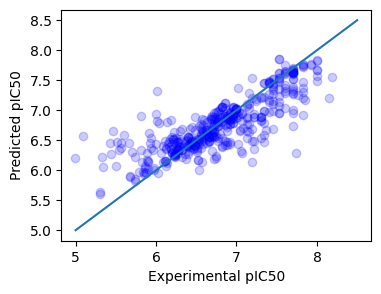

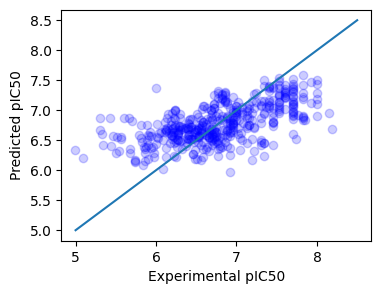

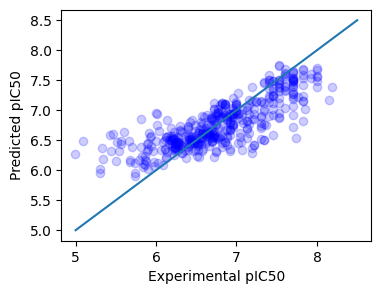

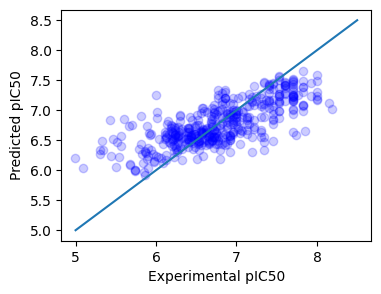

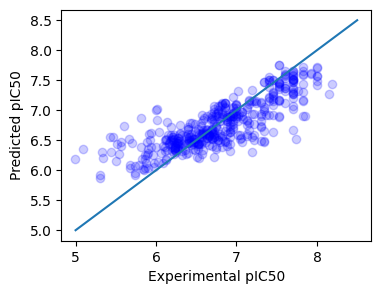

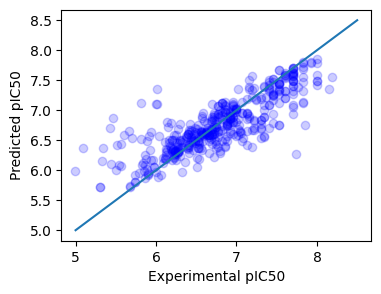

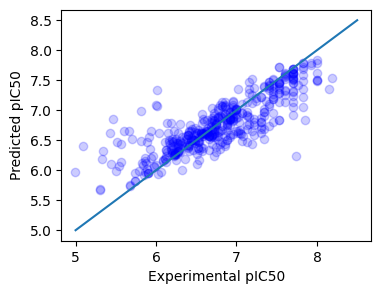

In [55]:
for Xtype in ["Xfp", "Xosmall", "Xsmall","Xofull","Xfull","Xrdkit","Xfprdkit"]:
    plt.figure(figsize=[4,3])
    plt.plot(y_test_all[Xtype], y_pred_all[Xtype], 'bo' ,alpha=.2)
    plt.plot([5,8.5],[5,8.5])
    plt.ylabel("Predicted pIC50")
    plt.xlabel("Experimental pIC50")
    plt.show()

In [56]:
Xfp_test = np.array([AllChem.GetMorganFingerprintAsBitVect(x, 2, 2048) for x in df_test['ROMol'].values])
Xrdkit_test = pd.DataFrame([Descriptors.CalcMolDescriptors(x) for x in df_test['ROMol'].values]).values
y_test = df_test['pIC50'].values.astype(float)

Xfull_test = np.concatenate([Xfp_test, df_test[full].values], axis=1)
Xsmall_test = np.concatenate([Xfp_test, df_test[small].values], axis=1)
Xofull_test = df_test[full].values
Xosmall_test = df_test[small].values
Xfprdkit_test = np.concatenate([Xfp_test, Xrdkit_test], axis=1)

[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerator
[16:15:23] DEPRECATION WARNING: please use MorganGenerat

In [57]:
r2all = dict()
maeall = dict()
y_test_all = dict()
y_pred_all = dict()
impall = dict()
rall = dict()

Xall_test = dict({"Xfp":Xfp_test, "Xosmall":Xosmall_test, "Xsmall":Xsmall_test, 
                  "Xofull":Xofull_test, "Xfull":Xfull_test, "Xrdkit":Xrdkit_test, "Xfprdkit":Xfprdkit_test})

for Xtype in ["Xfp", "Xosmall", "Xsmall", "Xofull", "Xfull","Xrdkit","Xfprdkit"]:
    X_test = Xall_test[Xtype]
    X = Xall[Xtype]
    #clf = XGBRegressor(n_estimators=1000, max_depth=3, n_jobs=-1)
    clf = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1)
    #clf = LinearRegression()
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    r2all[Xtype] = r2_score(y_test, y_pred)
    rall[Xtype] = np.corrcoef(y_pred, y_test)[0][1]
    maeall[Xtype] = mean_absolute_error(y_test, y_pred)
    y_test_all[Xtype] = y_test
    y_pred_all[Xtype] = y_pred
    if Xtype=='Xfp':
        imp = pd.DataFrame({"Feature":range(2048), "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xosmall':
        imp = pd.DataFrame({"Feature":small, "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xsmall':
        imp = pd.DataFrame({"Feature":np.hstack([range(2048),small]), "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xofull':
        imp = pd.DataFrame({"Feature":full, "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xfull':
        imp = pd.DataFrame({"Feature":np.hstack([range(2048),full]), "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xrdkit':
        imp = pd.DataFrame({"Feature":df_rdkit.columns, "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xfprdkit':
        imp = pd.DataFrame({"Feature":np.hstack([range(2048), df_rdkit.columns]), "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    impall[Xtype] = imp

In [58]:
for Xtype in ["Xfp", "Xosmall", "Xsmall","Xofull","Xfull","Xrdkit","Xfprdkit"]:
    print(Xtype)
    print("R2         = %.3f +/- %.3f" % (np.mean(r2all[Xtype]), np.std(r2all[Xtype])))
    print("Peasron r  = %.3f +/- %.3f" % (np.mean(rall[Xtype]), np.std(rall[Xtype])))
    print("MAE        = %.3f +/- %.3f" % (np.mean(maeall[Xtype]), np.std(maeall[Xtype])))
    print()

Xfp
R2         = 0.298 +/- 0.000
Peasron r  = 0.585 +/- 0.000
MAE        = 0.274 +/- 0.000

Xosmall
R2         = 0.272 +/- 0.000
Peasron r  = 0.552 +/- 0.000
MAE        = 0.294 +/- 0.000

Xsmall
R2         = 0.370 +/- 0.000
Peasron r  = 0.632 +/- 0.000
MAE        = 0.267 +/- 0.000

Xofull
R2         = 0.474 +/- 0.000
Peasron r  = 0.738 +/- 0.000
MAE        = 0.251 +/- 0.000

Xfull
R2         = 0.422 +/- 0.000
Peasron r  = 0.669 +/- 0.000
MAE        = 0.252 +/- 0.000

Xrdkit
R2         = 0.401 +/- 0.000
Peasron r  = 0.643 +/- 0.000
MAE        = 0.255 +/- 0.000

Xfprdkit
R2         = 0.444 +/- 0.000
Peasron r  = 0.677 +/- 0.000
MAE        = 0.241 +/- 0.000



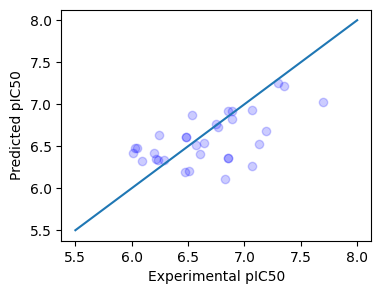

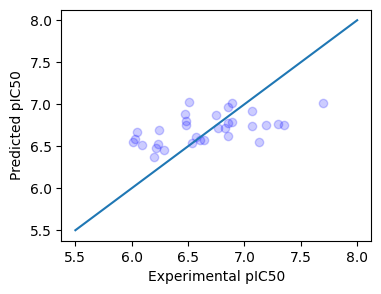

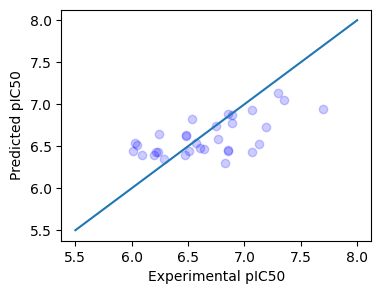

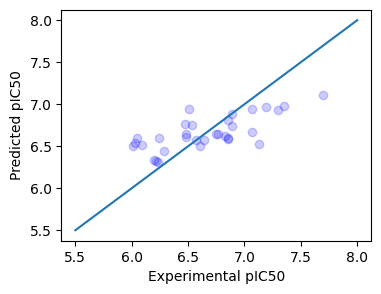

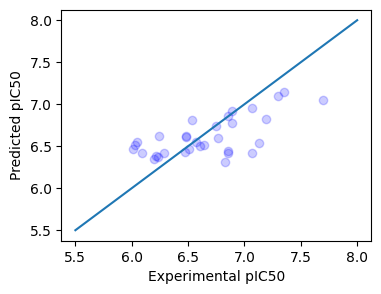

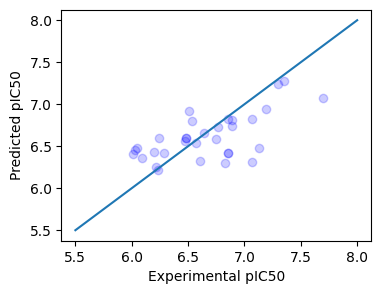

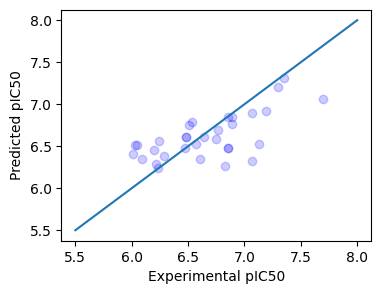

In [59]:
for Xtype in ["Xfp", "Xosmall", "Xsmall","Xofull","Xfull","Xrdkit","Xfprdkit"]:
    plt.figure(figsize=[4,3])
    plt.plot(y_test_all[Xtype], y_pred_all[Xtype], 'bo' ,alpha=.2)
    plt.plot([5.5,8],[5.5,8])
    plt.ylabel("Predicted pIC50")
    plt.xlabel("Experimental pIC50")
    plt.show()